You need to run
```bash
python src/run_trained_agents.py \
--has_cuda=0 \
--safe_max_rho 1.0 \
--limit_cs_margin 60 \
--expe_name figure_7 \
--nb_process XXX \
--path_agents saved_model
```
before this notebook

In [1]:
import matplotlib.pyplot as plt
import json
import os
import numpy as np
import grid2op
from lightsim2grid import LightSimBackend
from grid2op.utils import ScoreL2RPN2022
from src.mixture_experts import make_agent

In [2]:
env_name = "input_data_test"
scores_mixture_experts = []

env = grid2op.make(env_name, backend=LightSimBackend())
with open(os.path.join(env._init_env_path, "scenarios_info_seeds.json")) as f:
    seeds = json.load(f)

env_seeds = [int(seeds[os.path.split(el)[-1]]["seed"]) for el in sorted(env.chronics_handler.real_data.subpaths)]
scorer = ScoreL2RPN2022(env, env_seeds, nb_process_stats=1, nb_scenario=len(env_seeds), verbose=2)
agent = make_agent(env, ".", "saved_model")
scores_mixture_experts, _, _ = scorer.get(agent)
scores_mixture_experts = np.array(scores_mixture_experts)

Starts the evaluation of the agent


episode: 100%|██████████| 52/52 [06:26<00:00,  7.43s/it]


Start the evaluation of the scores


In [3]:
scores_mixture_experts.mean()

24.467333107990346

In [4]:
path = "."
with open (os.path.join(path, "agents_runs_figure_8.json"), "r") as f:
    dict_all_ = json.load(f)

In [5]:
scores_per_agent_per_scenarios = []
for safe_max_rho_, dict_f in dict_all_.items():
    for limit_cs_margin_, res_margin in dict_f.items():
        for training_iter_, res_iter in res_margin.items():
            score_this = []
            nb_survived_this = []
            for weights_dir_str, tmp_res_model in res_iter.items():
                scores_per_agent_per_scenarios.append(tmp_res_model["scores"])
scores_per_agent_per_scenarios = np.array(scores_per_agent_per_scenarios)

In [6]:
min_agents = scores_per_agent_per_scenarios.min(axis=0)
max_agents = scores_per_agent_per_scenarios.max(axis=0)
best_agent = scores_per_agent_per_scenarios[scores_per_agent_per_scenarios.mean(axis=1).argmax()]

mean_agent = scores_mixture_experts.mean()
mean_best_agent = best_agent.mean()

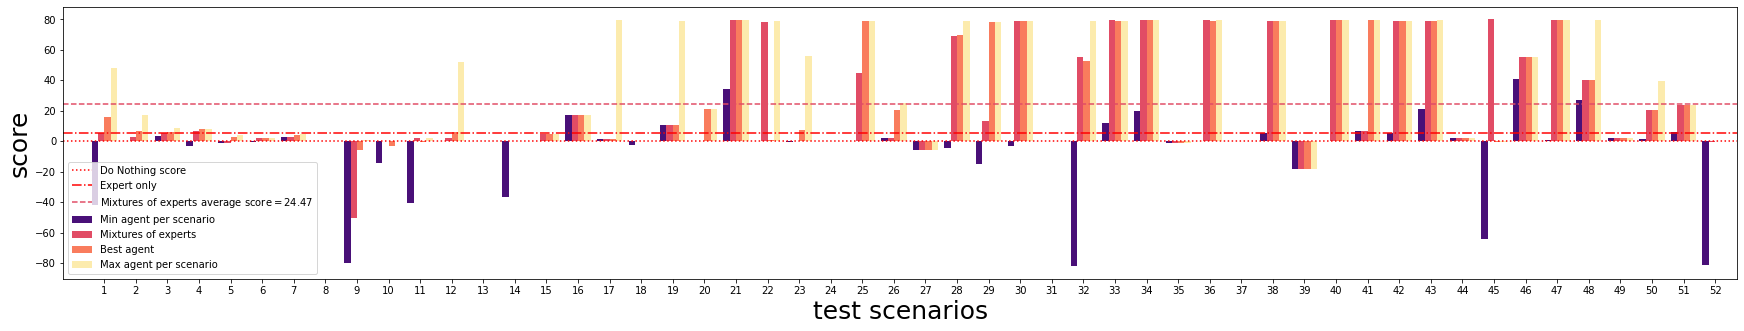

In [7]:
scenarios = np.array(range(1, scores_mixture_experts.shape[0]+1))
width = 0.2
plt.figure(figsize=(30, 5))
plt.bar(scenarios, min_agents, width, label="Min agent per scenario", color="#491078")
plt.bar(scenarios+width, scores_mixture_experts, width, label="Mixtures of experts", color="#e14c65")
plt.bar(scenarios+width*2, best_agent, width, label="Best agent", color="#f97c5d")
plt.bar(scenarios+width*3, max_agents, width, label="Max agent per scenario", color="#fcebad")
plt.axhline(0, label=f"Do Nothing score", color="red", linestyle=':')
plt.axhline(5.44, label=f"Expert only", color="red", linestyle='-.')
plt.axhline(mean_agent, label=f"Mixtures of experts average score$={mean_agent:.2f}$", linestyle="--", color="#e14c65")
#plt.axhline(mean_agent, label=f"Best agent average score$={mean_best_agent:.2f}$", linestyle="--", color="#f97c5d")
plt.ylabel("score", fontsize=25)
plt.xlabel("test scenarios", fontsize=25)
plt.xticks(scenarios+1.5*width, scenarios)
plt.xlim((0, scenarios[-1]+1))
_=plt.legend()
plt.savefig("figure8.pdf")